In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Data Loading and Initial Inspection

First we load the ANSUR II Male and Female public datasets, select the required columns, and perform initial descriptive analysis.

In [28]:
# Load the data
male_data_path = "../data/ANSUR II MALE Public.csv"
female_data_path = "../data/ANSUR II FEMALE Public.csv"
male_df = pd.read_csv(male_data_path, encoding='ISO-8859-1')
female_df = pd.read_csv(female_data_path, encoding='ISO-8859-1')

# Standardize subject ID column name
female_df = female_df.rename(columns={"SubjectId": "subjectid"})

# Our subset of columns
cols = ["subjectid",
        "Gender",
        "span",
        "stature",
        "footlength",
        "forearmhandlength",
        "handlength"]

# Subset datasets, with explicitly labeled gender
male_df = male_df[cols]
female_df = female_df[cols]
male_df["Gender"] = "Male"
female_df["Gender"] = "Female"

## Dataset Description

In [29]:
df = pd.concat([male_df, female_df], ignore_index=True)

print("The shape of the Male Dataset is:", male_df.shape)
print("The shape of the Female Dataset is:", female_df.shape)
print("The combined dataset is:", df.shape)

The shape of the Male Dataset is: (4082, 7)
The shape of the Female Dataset is: (1986, 7)
The combined dataset is: (6068, 7)


In [30]:
male_df.head()

,subjectid,Gender,span,stature,footlength,forearmhandlength,handlength
0,10027,Male,1782,1776,273,477,193
1,10032,Male,1745,1702,263,476,195
2,10033,Male,1867,1735,270,491,203
3,10092,Male,1708,1655,267,467,194
4,10093,Male,2035,1914,305,550,218


In [31]:
female_df.head()

,subjectid,Gender,span,stature,footlength,forearmhandlength,handlength
0,10037,Female,1647,1560,246,432,184
1,10038,Female,1751,1665,249,463,189
2,10042,Female,1779,1711,265,469,195
3,10043,Female,1708,1660,265,455,186
4,10051,Female,1702,1572,247,447,187


In [32]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   subjectid          6068 non-null   int64
 1   Gender             6068 non-null   str  
 2   span               6068 non-null   int64
 3   stature            6068 non-null   int64
 4   footlength         6068 non-null   int64
 5   forearmhandlength  6068 non-null   int64
 6   handlength         6068 non-null   int64
dtypes: int64(6), str(1)
memory usage: 332.0 KB
None


This shows us that all selected measurements are numerical and there are no missing values in the dataset, so we can proceed with our calculations.

## Ratio 1: Arm Span vs Stature
This calculates the commonly cited claim that arm span is approximately equal to standing height, having the ratio of 1-to-1.

**Null hypothesis**: The mean ratio equals 1.

**Alternative hypothesis**: The mean ratio differs from 1.

In [33]:
# Let's look at the span:stature ratio statistics
df["span_to_stature"] = df["span"] / df["stature"]
df["span_to_stature"].describe()

count    6068.000000
mean        1.028584
std         0.028699
min         0.914938
25%         1.009144
50%         1.026949
75%         1.046958
max         1.151163
Name: span_to_stature, dtype: float64

In [34]:
# Let's compare the expected ratio to average calculated ratio
ratio1_exp = 1.0
ratio1_avg = df["span_to_stature"].mean()
ratio1_std = df["span_to_stature"].std()
ratio1_var = df["span_to_stature"].var()

ratio1_ci = stats.t.interval(
    0.95,
    len(df)-1,
    loc=ratio1_avg,
    scale=stats.sem(df["span_to_stature"])
)

print("Commonly Expected Ratio is:", ratio1_exp)
print(f"ANSUR Calculated Average Ratio  is: {ratio1_avg:.4f}")
print(f"The 95% confidence interval is ({ratio1_ci[0]:.4f}, {ratio1_ci[1]:.4f})")

Commonly Expected Ratio is: 1.0
ANSUR Calculated Average Ratio  is: 1.0286
The 95% confidence interval is (1.0279, 1.0293)


The 95% CI does not include the expected ratio of 1.0. This should suggest that we need to reject the null hypothesis that the true mean ratio equals 1 at the 5% significance level.

In [35]:
# Let's do error analysis on the ratios

def percent_error(observed, reference):
    return abs((observed - reference) / reference * 100)

error_ratio1 = percent_error(ratio1_avg, ratio1_exp)
print(f'ANSUR Ratio 1 Percent Error is: {error_ratio1:.2f}%')

ANSUR Ratio 1 Percent Error is: 2.86%


Given that percent error is 2.86% (< 5%), the magnitude of the deviation is small, suggesting that the 1:1 ratio remains a useful approximation despite not being exact and not falling withing the 95% CI.

In [36]:
def summarize_ratio(df, ratio_col, gender_label):
    mean = df[ratio_col].mean()
    std = df[ratio_col].std()
    ci_low, ci_high = stats.t.interval(
        0.95,
        len(df) - 1,
        loc=mean,
        scale=stats.sem(df[ratio_col])
    )
    return {
        "Gender": gender_label,
        "Mean": mean,
        "Std Dev": std,
        "95% CI Lower": ci_low,
        "95% CI Upper": ci_high
    }
summary_table = pd.DataFrame([
    summarize_ratio(df[df["Gender"]=="Male"], "span_to_stature", "Male"),
    summarize_ratio(df[df["Gender"]=="Female"], "span_to_stature", "Female")
])

summary_table

,Gender,Mean,Std Dev,95% CI Lower,95% CI Upper
0,Male,1.033017,0.027371,1.032177,1.033857
1,Female,1.019473,0.029218,1.018188,1.020759


Divided by gender, both male and female groups show mean arm span–to–stature ratios greater than the commonly cited 1:1 relationship. The 95% confidence intervals for both groups exclude 1.0, showing statistically significant deviations from the expected ratio. Meaning that 95% of both male and female span-to-stature calculated ratios were above 1.0. Then we can also reject the null hypothesis for both gender subsets, ANSUR data suggest that true proportional relationship of arm span is a bit larger than stature.

In [37]:
# Now lets look at separate percent error
gender_ratio1 = df.groupby("Gender")["span_to_stature"].mean()
f_ratio1, m_ratio1 = gender_ratio1["Female"], gender_ratio1["Male"]

m_error_ratio1, f_error_ratio1 = percent_error(m_ratio1, ratio1_exp), percent_error(f_ratio1, ratio1_exp)
print(f'ANSUR Male Ratio 1 Percent Error is: {m_error_ratio1:.2f}%')
print(f'ANSUR Female Ratio 1 Percent Error is: {f_error_ratio1:.2f}%')

ANSUR Male Ratio 1 Percent Error is: 3.30%
ANSUR Female Ratio 1 Percent Error is: 1.95%


The male data subset percent error is 3.3% while the female data subset percent error is 1.95%. They are both still <5% meaning each subgroup, even though the datasets do not include 1.0 in their 95% CI, are still close enough to support the commonly cited 1:1 arm span to stature ratio. The female percent error represents an improvement of 1.35 percentage points and a relative error reduction of approximately 41%, despite being evaluated on a smaller (but still large) sample.

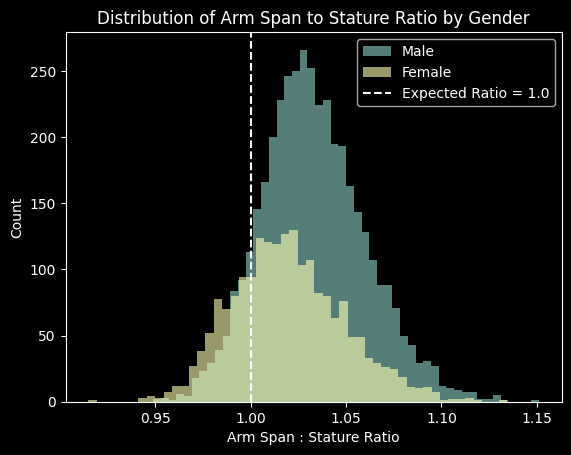

In [38]:
fig_dir = os.path.join("..", "figures")

plt.figure()
plt.hist(df[df["Gender"] == "Male"]["span_to_stature"], bins=50, alpha=0.6, label="Male")
plt.hist(df[df["Gender"] == "Female"]["span_to_stature"], bins=50, alpha=0.6, label="Female")

plt.axvline(1.0, linestyle="--", label="Expected Ratio = 1.0")
plt.xlabel("Arm Span : Stature Ratio")
plt.ylabel("Count")
plt.title("Distribution of Arm Span to Stature Ratio by Gender")
plt.legend()
fig_path = os.path.join(fig_dir, "Distribution_Arm_Span_to_Stature_Gender.png")
plt.savefig(fig_path, dpi=300)
plt.show()

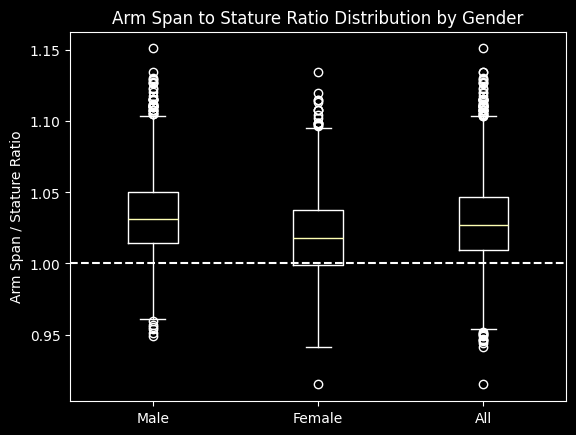

In [39]:
plt.figure()
plt.boxplot(
    [df[df["Gender"] == "Male"]["span_to_stature"],
     df[df["Gender"] == "Female"]["span_to_stature"],
     df["span_to_stature"]],
    labels=["Male", "Female", "All"]
)
plt.axhline(1.0, linestyle="--")
plt.ylabel("Arm Span / Stature Ratio")
plt.title("Arm Span to Stature Ratio Distribution by Gender")
fig_path = os.path.join(fig_dir, "Box_Plot_Ratio1_Gender.png")
plt.savefig(fig_path, dpi=300)
plt.show()


## Conclusion on Ratio 1
* The mean arm span–to–stature ratio is larger than the commonly cited 1:1 proportion for the male, female, and combined ANSUR II populations.
* For all groups, the 95% confidence interval for the mean excludes the reference value of 1.0, leading to rejection of the null hypothesis that the true mean ratio equals 1.
* Although these deviations are statistically significant, their magnitude is small, with relative differences below 5%, indicating that the 1:1 ratio remains a reasonable approximation rather than an exact biological constant.
* Gender analysis shows that females have a mean ratio closer to the reference value, with approximately 41% less deviation from 1.0 compared to males.
* This difference is visually supported by the boxplot, where the female interquartile range includes the reference value of 1.0, while the male and combined interquartile range lies entirely above it.
* Overall, the results suggest subtle but consistent gender differences in proportional relationships while reinforcing the practical usefulness of the traditional 1:1 guideline.


## Ratio 2: Foot Length vs Forearm Length

The common known ratio is that the length of the foot is approximately 1-to-1 the length of the inside of the forearm.
In the ANSUR dataset we have columns for `forearmhandlength` (from outside elbow to tip of middle finger) and `handlength` (from wrist to tip of middle finger), the difference between the two will give us **forearm length** (from outside elbow to wrist). However, this does not give us the measurement of the **inside forearm** (from inside crease of elbow to wrist), therefore, we can adjust for the extra “outside elbow to inside elbow” distance, lets name it E. The value E is on average around 2cm = 20mm, this is what we will use for the adjusted inside forearm calculation.

Again we want to test:

**Null hypothesis**: The mean ratio equals 1.

**Alternative hypothesis**: The mean ratio differs from 1.


In [40]:
E = 20 #extra elbow measurement
df["forearmlength"] = df["forearmhandlength"] - df["handlength"] # length from outside elbow to wrist
df["foot_to_forearm_outside"] = df["footlength"] / (df["forearmlength"])
df["foot_to_forearm_inside"] = df["footlength"] / (df["forearmlength"] - E)

df[["foot_to_forearm_outside", "foot_to_forearm_inside"]].describe()

,foot_to_forearm_outside,foot_to_forearm_inside
count,6068.000000,6068.000000
mean,0.948414,1.022597
std,0.039337,0.045440
min,0.788644,0.841751
25%,0.920962,0.991588
50%,0.948148,1.022472
75%,0.974910,1.052846
max,1.192513,1.335329


In [41]:
ratio2_exp = 1.0
ratio2_avg_outside = df["foot_to_forearm_outside"].mean()
ratio2_avg_inside = df["foot_to_forearm_inside"].mean()

ratio2_out_ci = stats.t.interval(
    0.95,
    len(df)-1,
    loc=ratio2_avg_outside,
    scale=stats.sem(df["foot_to_forearm_outside"])
)

ratio2_in_ci = stats.t.interval(
    0.95,
    len(df)-1,
    loc=ratio2_avg_inside,
    scale=stats.sem(df["foot_to_forearm_inside"])
)

print("Commonly Expected Ratio 2 is:", ratio2_exp)
print(f"ANSUR Average Ratio 2 is: {ratio2_avg_outside:.4f}")
print(f"The 95% CI of Ratio 2 is ({ratio2_out_ci[0]:.4f}, {ratio2_out_ci[1]:.4f})")
print(f"ANSUR Adjusted Average Ratio 2 is: {ratio2_avg_inside:.4f}")
print(f"The 95% CI of Ratio 2 is ({ratio2_in_ci[0]:.4f}, {ratio2_in_ci[1]:.4f})")


Commonly Expected Ratio 2 is: 1.0
ANSUR Average Ratio 2 is: 0.9484
The 95% CI of Ratio 2 is (0.9474, 0.9494)
ANSUR Adjusted Average Ratio 2 is: 1.0226
The 95% CI of Ratio 2 is (1.0215, 1.0237)


The 95% CI does not include the expected ratio of 1.0 for neither of the two calculations. This should suggest that we need to reject the null hypothesis that the true mean ratio equals 1 at the 5% significance level. The tight confidence interval shows that 95% of values in the calculated `foot_to_forearm_outsdie` and `foot_to_forearm_inside` are very close to their respective means, and since the mean values are not 1.0, the expected ratio does not fall into the range. So statistically based only on the adjusted ANSUR data the ratio of foot to forearm is larger than 1.0.

In [42]:
# Let's look at the percent error for each
error_ratio2_out = percent_error(ratio2_avg_outside, ratio2_exp)
error_ratio2_in = percent_error(ratio2_avg_inside, ratio2_exp)
print(f'ANSUR Ratio 2 Percent Error is: {error_ratio2_out:.2f}%')
print(f'ANSUR Adjusted Ratio 2 Percent Error is: {error_ratio2_in:.2f}%')

ANSUR Ratio 2 Percent Error is: 5.16%
ANSUR Adjusted Ratio 2 Percent Error is: 2.26%


The percent error is 5.16% (> 5% and < 10%) for the "foot/outside elbow to wrist" ratio calculated using the ANSUR data, meaning that even though the expected value does not fall into the 95%CI as shown above, the common ratio of 1 is still relatively close to be an approximation of the true calculated ratio. We can also say that the adjusted ANSUR ratio of 2.26% is an even better supporter of the claim, as it is an improvement of 2.9 percentage points and a relative error reduction of approximately 56%. Moving forward let us only focus on the distribution of the adjusted foot to inside forearm ratios.


In [43]:
gender_stats2_in = df.groupby("Gender")["foot_to_forearm_inside"].describe()
gender_stats2_in

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,1986.0,1.033363,0.047105,0.893878,1.000000,1.034188,1.064103,1.335329
Male,4082.0,1.017359,0.043664,0.841751,0.988235,1.015810,1.047291,1.257642


In [44]:
summary_table2 = pd.DataFrame([
    summarize_ratio(df[df["Gender"]=="Male"], "foot_to_forearm_inside", "Male"),
    summarize_ratio(df[df["Gender"]=="Female"], "foot_to_forearm_inside", "Female")
])

summary_table2

,Gender,Mean,Std Dev,95% CI Lower,95% CI Upper
0,Male,1.017359,0.043664,1.016019,1.018699
1,Female,1.033363,0.047105,1.031290,1.035436


The summary table for adjusted ratios 2 shows that this time around the male data was closer to the expected values. Male foot-to-inisde forearm mean is closer to the value 1.0 than the female mean. However, both CIs still exclude the null hypothesis value 1.0.

In [45]:
# Now lets divide the data by genders and analyze them separately
gender_ratio2_out = df.groupby("Gender")["foot_to_forearm_outside"].mean()
f_ratio2_out, m_ratio2_out = gender_ratio2_out["Female"], gender_ratio2_out["Male"]

gender_ratio2_in = df.groupby("Gender")["foot_to_forearm_inside"].mean()
f_ratio2_in, m_ratio2_in = gender_ratio2_in["Female"], gender_ratio2_in["Male"]

m_error_ratio2_out, f_error_ratio2_out = percent_error(m_ratio2_out, ratio2_exp), percent_error(f_ratio2_out, ratio2_exp)
m_error_ratio2_in, f_error_ratio2_in = percent_error(m_ratio2_in, ratio2_exp), percent_error(f_ratio2_in, ratio2_exp)

print("Male ANSUR Average Ratio 2 is:", m_ratio2_out)
print("Male ANSUR Adjusted Average Ratio 2 is:", m_ratio2_in)
print(f'Male ANSUR Ratio 2 Percent Error is: {m_error_ratio2_out:.2f}%')
print(f'Male ANSUR Adjusted Ratio 2 Percent Error is: {m_error_ratio2_in:.2f}%')
print()
print("Female ANSUR Average Ratio 2 is:", f_ratio2_out)
print("Female ANSUR Adjusted Average Ratio 2 is:", f_ratio2_in)
print(f'Female ANSUR Ratio 2 Percent Error is: {f_error_ratio2_out:.2f}%')
print(f'Female ANSUR Adjusted Ratio 2 Percent Error is: {f_error_ratio2_in:.2f}%')

Male ANSUR Average Ratio 2 is: 0.9461441952552544
Male ANSUR Adjusted Average Ratio 2 is: 1.0173593025421523
Male ANSUR Ratio 2 Percent Error is: 5.39%
Male ANSUR Adjusted Ratio 2 Percent Error is: 1.74%

Female ANSUR Average Ratio 2 is: 0.9530804988531132
Female ANSUR Adjusted Average Ratio 2 is: 1.033363401403772
Female ANSUR Ratio 2 Percent Error is: 4.69%
Female ANSUR Adjusted Ratio 2 Percent Error is: 3.34%


The relative percent error of the calculated adjusted mean and the expected mean for both gender is less than 5%, meaning that the mean values are still relatively close to the expected value 1.0, even if statistical analysis excludes it from ANSUR confidence intervals. This time around the male data shows a 1.6% points more relative closeness to the expected value, or in other words male mean deviates from the expected 1.0 value 46% less than the female mean.

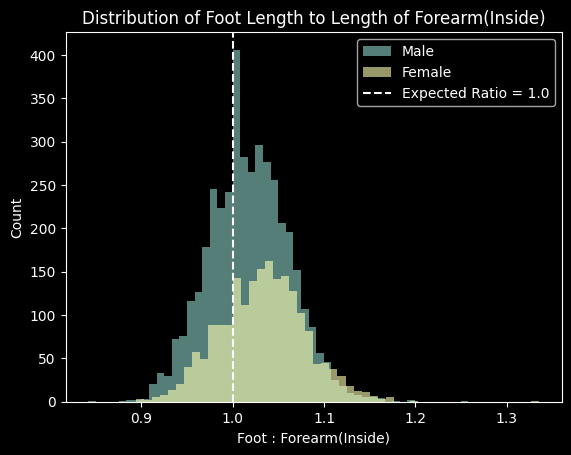

In [46]:
plt.figure()
plt.hist(df[df["Gender"] == "Male"]["foot_to_forearm_inside"], bins=50, alpha=0.6, label="Male")
plt.hist(df[df["Gender"] == "Female"]["foot_to_forearm_inside"], bins=50, alpha=0.6, label="Female")

plt.axvline(1.0, linestyle="--", label="Expected Ratio = 1.0")
plt.xlabel("Foot : Forearm(Inside)")
plt.ylabel("Count")
plt.title("Distribution of Foot Length to Length of Forearm(Inside)")
plt.legend()
fig_path = os.path.join(fig_dir, "Distribution_Foot_to_Forearm_Gender.png")
plt.savefig(fig_path, dpi=300)
plt.show()

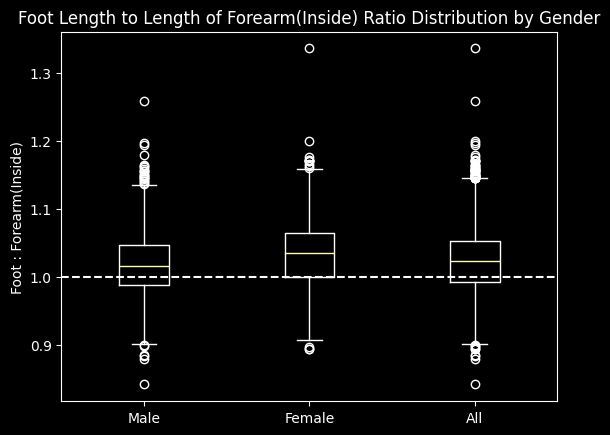

In [47]:
plt.figure()
plt.boxplot(
    [df[df["Gender"] == "Male"]["foot_to_forearm_inside"],
     df[df["Gender"] == "Female"]["foot_to_forearm_inside"],
     df["foot_to_forearm_inside"]],
    labels=["Male", "Female", "All"]
)
plt.axhline(1.0, linestyle="--")
plt.ylabel("Foot : Forearm(Inside)")
plt.title("Foot Length to Length of Forearm(Inside) Ratio Distribution by Gender")
fig_path = os.path.join(fig_dir, "Box_Plot_Ratio2_Gender.png")
plt.savefig(fig_path, dpi=300)
plt.show()


## Conclusion on Ratio 2
* The mean foot-to-forearm ratio is larger than the commonly cited 1:1 proportion for the male, female, and combined ANSUR II populations.
* For all groups, the 95% confidence interval for the mean excludes the reference value of 1.0, leading to rejection of the null hypothesis that the true mean ratio equals 1.
* Although these deviations are statistically significant, their magnitude is small, with relative differences below 5%, indicating that the 1:1 ratio remains a reasonable approximation rather than an exact biological constant.
* Gender analysis shows that males have a mean ratio closer to the reference value, with approximately 47% less deviation from 1.0 compared to females.
* This difference is visually supported by the boxplot, where the male interquartile range includes the reference value of 1.0, the combined also includes it, while the female is bordering on the range.
* Overall, the results suggest subtle but consistent gender differences in proportional relationships while reinforcing the practical usefulness of the traditional 1:1 guideline.
